# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях». Целью проекта является построение модели, предсказывающей возможный отказ клиентов, забронировавших номера, от брони для работы с такими клиентами на условиях бронирования номеров только при внесении депозита.  В распоряжение представлены данные клиентских систем за 2015-2016 годы - для обучения модели и за 2017 год - для тестирования. Бюджет заказа - 400000  рублей. В ходе исследования также необходимо проанализировать какую прибыль получит заказчик после внедрения системы, выделить типичные признаки, указывающие на то, что клиент склонен к отказу от забронированного места в отеле. 

Перед началом исследования проведем предварительную обработку данных: удалим дубликаты, аномальные значения, при необходимости изменим тип данных. Для произведения расчетов окупаемости модели напишем функции, подсчитывающие прибыль отеля при безусловном бронировании номеров и на условиях депозитов с "ненадежных" клиентов.

В соответствии с условием проекта построим и обучим разные модели, подобрав наилучшие гиперпараметры. Оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке. 


На основе исследовательского анализа данных выведем признаки клиента, склонного к отказу от брони. Сделаем выводы.

## Подготовка данных

Импортируем библиотеку pandas, а также структуры библиотеки sklearn, необходимые для построения и проверки качества работы моделей.

In [1]:
import pandas as pd
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Читаем файлы '/datasets/hotel_train.csv' и '/datasets/hotel_test.csv' и сохраняем в переменных data_train и data_test соответственно.

In [2]:
data_hotel_train = pd.read_csv('C:/Users/User/Downloads/hotel_train.csv')  
display(data_hotel_train)
data_hotel_train.info()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65224,84057,0,23.0,2016,December,53,30,2,4,2.0,...,0,0,0,D,0,0,Transient,0,2,6
65225,84063,0,53.0,2016,December,53,31,2,3,2.0,...,0,0,0,D,0,0,Transient,0,3,5
65226,84094,0,7.0,2016,December,53,31,2,4,2.0,...,0,0,0,D,0,0,Transient,0,1,6
65227,84117,0,17.0,2016,December,53,30,2,5,2.0,...,0,0,0,A,0,0,Transient,0,1,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [3]:
data_hotel_test = pd.read_csv('C:/Users/User/Downloads/hotel_test.csv')
display(data_hotel_test)
data_hotel_test.info()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164.0,2017,August,35,31,2,4,2.0,...,0,0,0,A,0,0,Transient,0,0,6
32408,97900,0,21.0,2017,August,35,30,2,5,2.0,...,0,0,0,A,0,0,Transient,0,2,7
32409,97901,0,23.0,2017,August,35,30,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7
32410,97902,0,34.0,2017,August,35,31,2,5,2.0,...,0,0,0,D,0,0,Transient,0,4,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

## Предобработка и исследовательский анализ данных

В учебном и тестовом наборах одинаковые столбцы в связи с чем их предобработку будем проводить параллельно. Для контроля объема данных в датасетах до и после предварительной обработки в отдельных переменных сохраним исходные датасеты.

In [4]:
a = data_hotel_train
b = data_hotel_test

Данные в столбцах 'lead_time', 'adults', 'children', 'babies' представлены типом "float", что противоестественно. Сделаем данные цельночисленными.

In [5]:
data_hotel_train[['lead_time', 'adults', 'children', 'babies']] = data_hotel_train[['lead_time', 'adults', 'children', 'babies']
                                                                      ].astype('int64')
data_hotel_test[['lead_time', 'adults', 'children', 'babies']] = data_hotel_test[['lead_time', 'adults', 'children', 'babies']
                                                                      ].astype('int64')
data_hotel_train.info()
data_hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              65229 non-null  int64 
 1   is_canceled                     65229 non-null  int64 
 2   lead_time                       65229 non-null  int64 
 3   arrival_date_year               65229 non-null  int64 
 4   arrival_date_month              65229 non-null  object
 5   arrival_date_week_number        65229 non-null  int64 
 6   arrival_date_day_of_month       65229 non-null  int64 
 7   stays_in_weekend_nights         65229 non-null  int64 
 8   stays_in_week_nights            65229 non-null  int64 
 9   adults                          65229 non-null  int64 
 10  children                        65229 non-null  int64 
 11  babies                          65229 non-null  int64 
 12  meal                            65229 non-null

В датасете столбцы 'arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type','customer_type' представлены типом 'object'. В некоторых из них обнаружены дубликаты и аномалии.

По столбцу 'meal' в значениях имеются пробелы, в том числе за счет которых образовались дубликаты 'SC' и 'SC '. Избавимся от пробелов методом str.strip()

In [6]:
print(data_hotel_train['meal'].sort_values().unique())
data_hotel_train['meal'] =  data_hotel_train['meal'].str.strip()
print(data_hotel_train['meal'].sort_values().unique())
print('')
print(data_hotel_test['meal'].sort_values().unique())
data_hotel_test['meal'] =  data_hotel_test['meal'].str.strip()
print(data_hotel_test['meal'].sort_values().unique())
print('')

['BB       ' 'FB       ' 'HB       ' 'SC' 'SC       ']
['BB' 'FB' 'HB' 'SC']

['BB       ' 'FB       ' 'HB       ' 'SC' 'SC       ']
['BB' 'FB' 'HB' 'SC']



По столбцу 'reserved_room_type' в значениях также есть пробелы, от которых также избавимся методом .str.strip()

In [7]:
print(data_hotel_train['reserved_room_type'].sort_values().unique())
data_hotel_train['reserved_room_type'] =  data_hotel_train['reserved_room_type'].str.strip()
print(data_hotel_train['reserved_room_type'].sort_values().unique())
print('')
print(data_hotel_test['reserved_room_type'].sort_values().unique())
data_hotel_test['reserved_room_type'] = data_hotel_test['reserved_room_type'].str.strip()
print(data_hotel_test['reserved_room_type'].sort_values().unique())
print('')

['A               ' 'B               ' 'C               '
 'D               ' 'E               ' 'F               '
 'G               ']
['A' 'B' 'C' 'D' 'E' 'F' 'G']

['A               ' 'B               ' 'C               '
 'D               ' 'E               ' 'F               '
 'G               ']
['A' 'B' 'C' 'D' 'E' 'F' 'G']



Посмотрим описание столбцов, представленных цельночисленным типом.

In [8]:
data_hotel_train[['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number','arrival_date_day_of_month',
      'stays_in_weekend_nights', 'stays_in_week_nights', 'is_repeated_guest', 'previous_cancellations', 
      'previous_bookings_not_canceled','booking_changes', 'days_in_waiting_list','required_car_parking_spaces',
       'total_of_special_requests', 'total_nights']].describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [9]:
data_hotel_test[['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number','arrival_date_day_of_month',
      'stays_in_weekend_nights', 'stays_in_week_nights', 'is_repeated_guest', 'previous_cancellations', 
      'previous_bookings_not_canceled','booking_changes', 'days_in_waiting_list','required_car_parking_spaces',
       'total_of_special_requests', 'total_nights']].describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


Для отдельных столбцов построим гистограммы

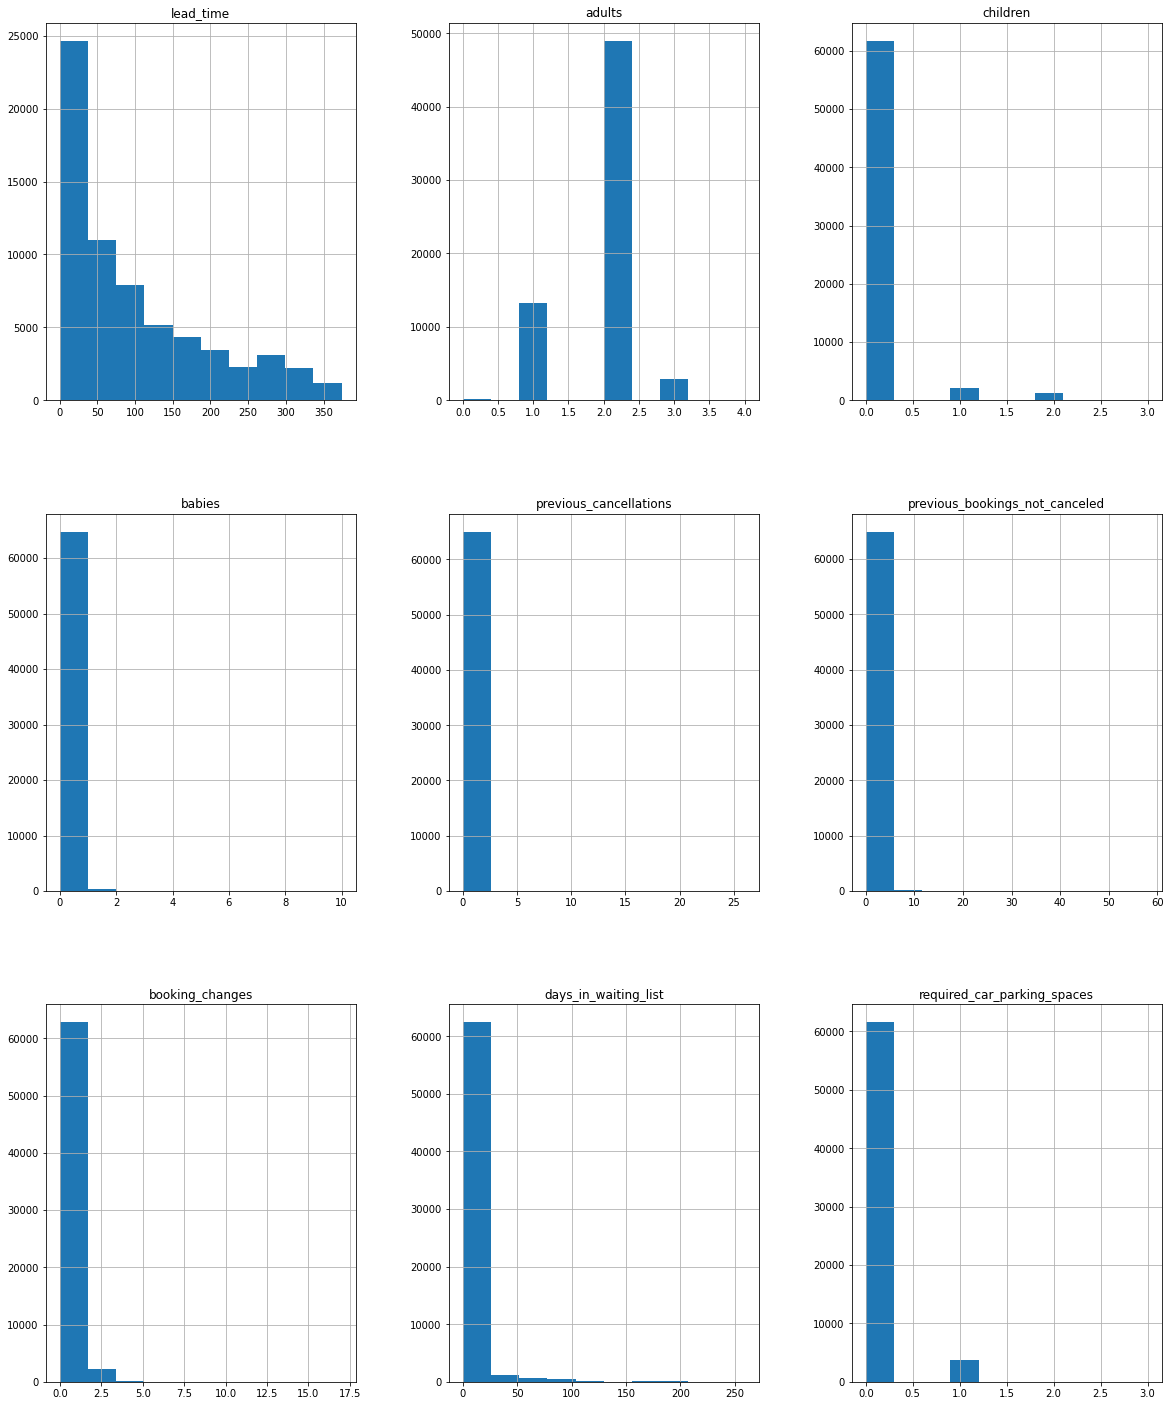

In [10]:
ax = data_hotel_train[['lead_time', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
          'booking_changes','days_in_waiting_list','required_car_parking_spaces']].hist(figsize=(20, 25))

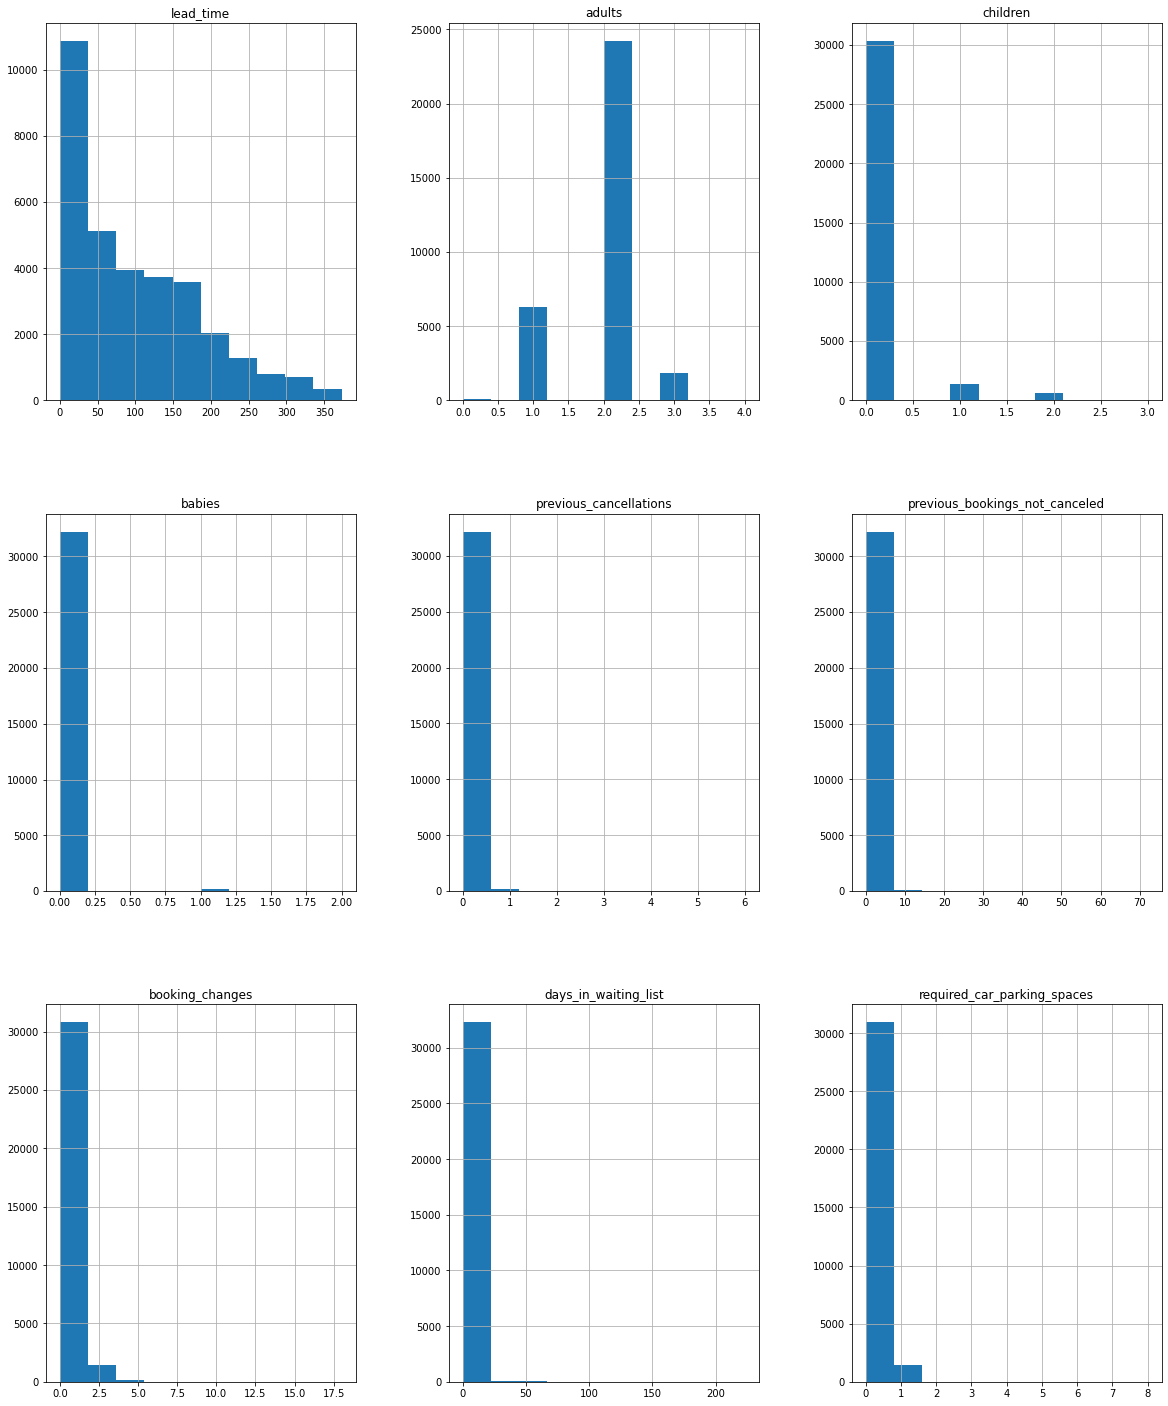

In [11]:
ax = data_hotel_test[['lead_time', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
          'booking_changes','days_in_waiting_list','required_car_parking_spaces']].hist(figsize=(20, 25))

На гистограмме столбца 'lead_time' видно, что к аномальным можно отнести значения за пределами 300 дней. Количество гостей, которые почти за год до заезда бронируют места в отеле по сравнению с общим числом мало, в связи с чем данные о них можно удалить.

In [12]:
data_hotel_train = data_hotel_train.query('lead_time <= 350').reset_index(drop=True)
print(data_hotel_train['lead_time'].sort_values().unique())
print('')
data_hotel_test = data_hotel_test.query('lead_time <= 350').reset_index(drop=True)
print(data_hotel_test['lead_time'].sort_values().unique())
print('')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

В столбце 'adults' минимальное значение указано 0, что свидетельствует об аномалии данных. Скорее всего информация о количестве взрослых гостей не была заполнена ошибочно. Посмотрим точное количество.

In [13]:
print(data_hotel_train['adults'].value_counts())
print(data_hotel_test['adults'].value_counts())

2    48465
1    13162
3     2856
0      166
4       13
Name: adults, dtype: int64
2    24070
1     6267
3     1811
0       68
4        9
Name: adults, dtype: int64


Таких строк всего 166 и 68, можно их удалить.

In [14]:
data = data_hotel_train.query('adults != 0.0').reset_index(drop=True)
print(data_hotel_train['adults'].value_counts())
print('')
data_hotel_test = data_hotel_test.query('adults != 0.0').reset_index(drop=True)
print(data_hotel_test['adults'].value_counts())
print('')

2    48465
1    13162
3     2856
0      166
4       13
Name: adults, dtype: int64

2    24070
1     6267
3     1811
4        9
Name: adults, dtype: int64



В данных data_hotel_train по столбцу 'babies' виден так называемый выброс по значениям 9-10. Гости с количеством 9 и 10 младенцев - явная аномалия. Но даже если это правда, то их количество единично и их удаление на исследование не повлияет.

In [15]:
print(data_hotel_train['babies'].value_counts())
print(data_hotel_test['babies'].value_counts())
print('')
data_hotel_train = data_hotel_train.query('babies <=3').reset_index(drop=True)
print(data_hotel_train['babies'].value_counts())
print('')

0     64211
1       446
2         3
9         1
10        1
Name: babies, dtype: int64
0    31984
1      169
2        4
Name: babies, dtype: int64

0    64211
1      446
2        3
Name: babies, dtype: int64



На гистограмме столбца 'booking_changes' видно, что в основном гости вносят по 1 изменению в заказ, значительно реже - по 2. Остальное количество изменений едва просматривается. Посмотрим все значения.

In [16]:
print(data_hotel_train['booking_changes'].value_counts())
print(data_hotel_test['booking_changes'].value_counts())

0     55707
1      6561
2      1739
3       403
4       148
5        42
6        18
7        18
8         7
9         5
13        4
10        2
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64
0     27534
1      3036
2      1151
3       265
4       116
5        28
6        15
7         5
16        1
18        1
8         1
10        1
11        1
14        1
15        1
Name: booking_changes, dtype: int64


Все, что превышает 4 изменения можно удалить ввиду малого количества значений.

In [17]:
data_hotel_train = data_hotel_train.query('booking_changes < 5').reset_index(drop=True)
print(data_hotel_train['booking_changes'].value_counts())
print('')
data_hotel_test = data_hotel_test.query('booking_changes < 5').reset_index(drop=True)
print(data_hotel_test['booking_changes'].value_counts())
print('')

0    55707
1     6561
2     1739
3      403
4      148
Name: booking_changes, dtype: int64

0    27534
1     3036
2     1151
3      265
4      116
Name: booking_changes, dtype: int64



На гистограмме столбца 'days_in_waiting_list' видно, что основная масса гостей отеля ожидала подтверждения заказа до 25 дней. Незначительная часть ожиданий просматривается от 25 до 50 дней. Все что находится за этим временным промежутком можно отнести к выбросам и удалить.

In [18]:
data_hotel_train = data_hotel_train.query('days_in_waiting_list <= 50').reset_index(drop=True)
print(data_hotel_train['days_in_waiting_list'].sort_values().unique())
print('')
data_hotel_test = data_hotel_test.query('days_in_waiting_list <= 50').reset_index(drop=True)
print(data_hotel_test['days_in_waiting_list'].sort_values().unique())
print('')

[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 17 19 20 21 22 24 25 27 28
 30 31 32 33 34 35 38 39 40 41 42 43 44 45 46 47 48 49 50]

[ 0  1  2  4  5  6  7  9 10 11 12 13 14 15 16 17 18 20 21 22 23 25 26 27
 28 30 31 32 33 34 35 36 38 39 43 44 46 47 49 50]



Контролируем отсутствие явных дубликатов

Для контроля явных дубликатов имеет значение их отсутствие в столбце 'id'. В остальных столбцах информация может многократно повторяться, поскольку тысячи людей бронируют номера в одних и тех же отелях и на одинаковых условиях.

In [19]:
print(data_hotel_train['id'].duplicated().sum())
print(data_hotel_test['id'].duplicated().sum())

0
0


In [20]:
print('Количество дубликатов на учебной выборке:',data_hotel_train.duplicated().sum())
print('Количество дубликатов на тестовой выборке:',data_hotel_test.duplicated().sum())

Количество дубликатов на учебной выборке: 0
Количество дубликатов на тестовой выборке: 0


Проверяем насколько после предварительной обработки уменьшились исходные датасеты

In [21]:
print("Учебный датасет уменьшился на",round((a['id'].count() - data_hotel_train['id'].count()
                                                    )/a['id'].count()*100), "%")

print("Тестовый датасет уменьшился на",round((b['id'].count() - data_hotel_test['id'].count()
                                                    )/b['id'].count()*100), "%")

Учебный датасет уменьшился на 4 %
Тестовый датасет уменьшился на 1 %


После предварительной обработки потеря данных в учебном датасете составила 4 %, в тестовом - 1 %, что приемлемо для проведения исследовательского анализа и построения модели предсказаний.

 Мы провели предварительную обработку данных, в ходе которой проделали следующее:    
 
  
данные столбцов 'lead_time', 'adults', 'children', 'babies', представленых типом "float", сделали цельночисленными;
    
    
неявные дубликаты в столбце 'meal', образовавшиеся за счет пробелов ('SC' и 'SC ') устранили методом str.strip(), этим же методом устранили пробелы в значениях столбца 'reserved_room_type';
    
    
в столбцах 'lead_time', 'adults', 'babies','booking_changes','days_in_waiting_list' удалили значения, являющиеся выбросами. 
    

После потеря данных в учебном датасете составила 4 %, в тестовом - 1 %, что приемлемо для проведения исследовательского анализа и построения модели предсказаний.

## Вычисляем бизнес-метрику

По условию проекта нам необходимо посчитать прибыль отеля, которая представляет собой разницу между стоимостью номера за все ночи и затраты на обслуживание как при подготовке номера, так и при проживании постояльца в зависимости от категории номера и сезонности.

Для подсчета прибыли напишем функцию, которая сформирует столбец с суммой прибыли (или убытка) по каждому номеру. В тело функции передадим следующие условия:

если клиент не отменял бронь, то прибыль отеля составит стоимость одной ночи номера заданной категории, умноженная на количество ночей и на сезонный коэффициент за минусом стоимости обслуживания номера, умноженного на количество ночей и на сезонный коэффициент и поделенного на 2 с округлением до целого числа в большую сторону (по условию уборка 1 раз в два дня);

если клиент отменил бронь без внесения депозита, то отель потерпит убытки, которые сложатся из стоимости номера определенной категории за сутки и однократной уборки, умноженные на сезонный коэффициент (все это со знаком минус).

Для произведения указанных рассчетов сначала дополним таблицу столбцами со стоимостью номера определенной категории и стоимостью его обслуживания на основе столбца 'reserved_room_type', после этого на основе столбца 'arrival_date_month' создадам столбец с сезонным коэффициентом, после чего произведем рассчеты прибыли (убытков).

Создаем функцию для столбца с сезонным коэффициентом

In [22]:
def coefficient(row):
    if (row == 'January'
     or  row == 'February'
     or row == 'December'):
        return '1'
    if (row == 'June'
        or row == 'July' 
        or row =='August'):
        return '1.4'
    else:
        return '1.2'
data_hotel_train['coefficient'] = data_hotel_train['arrival_date_month'].apply(coefficient)
data_hotel_test['coefficient'] = data_hotel_test['arrival_date_month'].apply(coefficient)
print(data_hotel_train['coefficient'].value_counts())
print(data_hotel_test['coefficient'].value_counts())

1.2    35813
1.4    16687
1      10433
Name: coefficient, dtype: int64
1.2    14219
1.4    11154
1       6662
Name: coefficient, dtype: int64


Создаем функцию для столбца со стоимостью номера

In [23]:
def room_price(row):
    if row == 'A':
        return '1000'
    if row == 'B': 
        return '800'
    if row == 'C':
        return '600'
    if row == 'D':
        return '550'
    if row == 'E': 
        return '500'
    if row == 'F':
        return '450'
    if row == 'G':
        return '350'
data_hotel_train['room_price'] = data_hotel_train['reserved_room_type'].apply(room_price)
data_hotel_test['room_price'] = data_hotel_test['reserved_room_type'].apply(room_price)
print(data_hotel_train['room_price'].value_counts())
print(data_hotel_test['room_price'].value_counts())

1000    48289
550      9347
500      2427
450      1205
800       851
350       588
600       226
Name: room_price, dtype: int64
1000    23226
550      6070
500      1628
450       500
350       276
600       200
800       135
Name: room_price, dtype: int64


Создаем функцию для столбца со стоимостью обслуживания номера

In [24]:
def room_prepare(row):
    if row == 'A':
        return '400'
    if (row == 'B'
       or row == 'C'): 
        return '350'
    else:
        return '150'
data_hotel_train['room_prepare'] = data_hotel_train['reserved_room_type'].apply(room_prepare)
data_hotel_test['room_prepare'] = data_hotel_test['reserved_room_type'].apply(room_prepare)
print(data_hotel_train['room_prepare'].value_counts())
print(data_hotel_test['room_prepare'].value_counts())

400    48289
150    13567
350     1077
Name: room_prepare, dtype: int64
400    23226
150     8474
350      335
Name: room_prepare, dtype: int64


In [25]:
data_hotel_train[['room_price','room_prepare']] = data_hotel_train[['room_price','room_prepare']].astype('int64')
data_hotel_train[['coefficient']] = data_hotel_train[['coefficient']].astype('float64')
data_hotel_test[['room_price','room_prepare']] = data_hotel_test[['room_price','room_prepare']].astype('int64')
data_hotel_test[['coefficient']] = data_hotel_test[['coefficient']].astype('float64')

Пишем функцию для подсчета прибыли

In [26]:
def profit(row):
    if row['is_canceled'] == 1:
        profit = 0 -((row['room_price'] + row['room_prepare'])*row['coefficient'])
    else:
        profit = row['room_price']*row['total_nights']*row['coefficient'] - row['room_prepare']*(np.ceil(row['total_nights']/2))*row['coefficient']
    return profit
data_hotel_train['profit'] = data_hotel_train.apply(profit, axis=1).astype('int64')
data_hotel_test['profit'] = data_hotel_test.apply(profit, axis=1).astype('int64')
data_hotel_train.info()
display(data_hotel_train.head())
print('')
data_hotel_test.info()
display(data_hotel_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62933 entries, 0 to 62932
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              62933 non-null  int64  
 1   is_canceled                     62933 non-null  int64  
 2   lead_time                       62933 non-null  int64  
 3   arrival_date_year               62933 non-null  int64  
 4   arrival_date_month              62933 non-null  object 
 5   arrival_date_week_number        62933 non-null  int64  
 6   arrival_date_day_of_month       62933 non-null  int64  
 7   stays_in_weekend_nights         62933 non-null  int64  
 8   stays_in_week_nights            62933 non-null  int64  
 9   adults                          62933 non-null  int64  
 10  children                        62933 non-null  int64  
 11  babies                          62933 non-null  int64  
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,coefficient,room_price,room_prepare,profit
0,0,0,7,2015,July,27,1,0,1,1,...,0,0,Transient,0,0,1,1.4,1000,400,840
1,1,0,14,2015,July,27,1,0,2,2,...,0,0,Transient,0,1,2,1.4,1000,400,2240
2,2,0,0,2015,July,27,1,0,2,2,...,0,0,Transient,0,0,2,1.4,600,350,1190
3,3,0,9,2015,July,27,1,0,2,2,...,0,0,Transient,0,1,2,1.4,600,350,1190
4,4,1,85,2015,July,27,1,0,3,2,...,0,0,Transient,0,1,3,1.4,1000,400,-1959



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32035 entries, 0 to 32034
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32035 non-null  int64  
 1   is_canceled                     32035 non-null  int64  
 2   lead_time                       32035 non-null  int64  
 3   arrival_date_year               32035 non-null  int64  
 4   arrival_date_month              32035 non-null  object 
 5   arrival_date_week_number        32035 non-null  int64  
 6   arrival_date_day_of_month       32035 non-null  int64  
 7   stays_in_weekend_nights         32035 non-null  int64  
 8   stays_in_week_nights            32035 non-null  int64  
 9   adults                          32035 non-null  int64  
 10  children                        32035 non-null  int64  
 11  babies                          32035 non-null  int64  
 12  meal                           

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,coefficient,room_price,room_prepare,profit
0,6086,1,74,2017,January,1,1,1,0,2,...,0,0,Transient,0,0,1,1.0,1000,400,-1400
1,6087,1,62,2017,January,1,1,2,2,2,...,0,0,Transient,0,1,4,1.0,1000,400,-1400
2,6088,1,62,2017,January,1,1,2,2,2,...,0,0,Transient,0,1,4,1.0,1000,400,-1400
3,6089,1,71,2017,January,1,1,2,2,1,...,0,0,Transient,0,1,4,1.0,1000,400,-1400
4,6090,1,172,2017,January,1,1,2,5,2,...,0,0,Transient,0,0,7,1.0,1000,400,-1400


Посчитаем прибыль отеля на учебной выборке, просуммировав данные столбца 'profit' по годам и за весь период.

In [27]:
print('Прибыль отеля за 2015 год составила:', data_hotel_train.query('arrival_date_year == 2015'
                                                              ).reset_index(drop=True)['profit'].sum(),'рублей')
print('Прибыль отеля за 2016 год составила:', data_hotel_train.query('arrival_date_year == 2016'
                                                              ).reset_index(drop=True)['profit'].sum(),'рублей')
print('Всего в учебной базе данных прибыль отеля равна', data_hotel_train['profit'].sum(),'рублей')

Прибыль отеля за 2015 год составила: 16592635 рублей
Прибыль отеля за 2016 год составила: 47526595 рублей
Всего в учебной базе данных прибыль отеля равна 64119230 рублей


 Мы посчитали прибыль отеля на учебной выборке за каждый год (2015 -16592635 рублей,  2016 - 47526595 рублей), а также общую - 64119230 рублей. Данная прибыль сложилась из стоимости номеров за вычетом затрат на обслуживание с учетом сезонного коэффициента. Также из прибыли исключены затраты при отказе потенциального клиента от  брони - стоимость 1 ночи в номере определенной категории и однократного его обслуживания. 


## Формулировка ML-задачи на основе бизнес-задачи

 Минимизировать убытки отеля при отказе клиента от забронированного номера возможно путем бронирования номеров  при условии внесения депозита, который не возвращается при отказе от брони.  Вместе с тем, чтоб "не отпугнуть" депозитом потенциальных клиентов, условие депозита необходимо применять только к склонным к отказу от брони, а не ко всем.

Для решения этой бизнес-задачи возможно (и необходимо) построить модель машинного обучения, способную на основе данных о клиентах, которые поступают в распоряжение отелей при бронировании номера, распознавать возможность последующего отказа от брони. Условие внесения депозита при бронировании предлагать только таким клиентам. 

На внедрение данной системы заказчиком предусмотрен бюджет в размере 400000 рублей.

Для построения модели машинного обучения представлены данные сети отелей «Как в гостях» о работе системы бронирования отелей за 2015 - 2017 годы, включающую информацию об отказе клиента от бронирования номера в виде бинарной классификации, в которой факт отказа клиента от брони представлен положительным классом 1, отсутствия такого отказа - отрицательным классом 0.

Наша задача состоит в построении модели машинного обучения по предсказанию отказа клиента от забронированного номера в отеле, получения предсказаний и оценки их метриками классификации.

Также необходимо подсчитать на тестовых данных (за 2017 год) потенциальную прибыль заказчика, если бы в его распоряжении работала такая модель и предсказывала возможность отказа клиента от брони.Данная прибыль будет состоять из прибыли отеля, которую он получил при предоставлении своих услуг за вычетом расходов при отказе от брони (с учетом внесенного депозита при правильном предсказании) и вычетом средств на внедрение модели.

Если полученная таким образом потенциальная прибыль отельной сети будет достаточной, модель машинного обучения возможно будет внедрить.


## Разработка модели ML

Для построения модели предсказаний из учебной и тестовой выборок создаем выборки, содержащие признаки и целевой признак.

Целевой признак содержится в столбце 'is_canceled', поскольку целью построения модели является предсказание факта отказа потенциального клиента от брони.

Среди остальных признаков (столбцов) имеются так называемые фиктивные признаки, которые не могут и не должны влиять на предсказания нашей будущей модели относительно факта отказа клиента от брони. Эти признаки - столбцы 'id', 'is_canceled', 'arrival_date_year', 'arrival_date_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'arrival_date_day_of_month','distribution_channel', 'booking_changes', 'sample', 'coefficient', 'room_price','room_prepare', 'profit':

'id' - сам по себе неинформативный признак;

'is_canceled' - целевой признак;

'arrival_date_year' - номер прошедшего года не имеет значения, так как строится модель предсказаний на будущие периоды;

'arrival_date_month' и 'arrival_date_day_of_month' - информация о месяце и дате месяца содержится в столбце номера недели 'arrival_date_week_number';

'stays_in_weekend_nights' и 'stays_in_week_nights' - данные этих столбцов саккумулированны в столбце 'total_nights';

'distribution_channel' - не важен, поскольку не имеет хначения как клиент попал на сайт отеля;

'sample' - был временный столбец для объединения и разделения датасетов, который исполнил свою функцию;

'coefficient', 'room_price','room_prepare' и 'profit' - были созданы в процессе исследования для подсчета прибыли.

Указанные признаки удаляем.

### Подготовка признаков и целевого признака

In [28]:
features_train = data_hotel_train.drop(['id', 'is_canceled', 'arrival_date_year','arrival_date_month', 'stays_in_weekend_nights',
                                      'stays_in_week_nights','arrival_date_day_of_month','distribution_channel','coefficient',
                                        'room_price','room_prepare', 'profit'], axis=1)  
target_train = data_hotel_train['is_canceled']

display(features_train)
display(target_train)

,lead_time,arrival_date_week_number,adults,children,babies,meal,country,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,7,27,1,0,0,BB,GBR,0,0,0,A,0,0,Transient,0,0,1
1,14,27,2,0,0,BB,GBR,0,0,0,A,0,0,Transient,0,1,2
2,0,27,2,0,0,BB,PRT,0,0,0,C,0,0,Transient,0,0,2
3,9,27,2,0,0,FB,PRT,0,0,0,C,0,0,Transient,0,1,2
4,85,27,2,0,0,BB,PRT,0,0,0,A,0,0,Transient,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62928,23,53,2,0,0,BB,CHN,0,0,0,D,0,0,Transient,0,2,6
62929,53,53,2,0,0,HB,FRA,0,0,0,D,0,0,Transient,0,3,5
62930,7,53,2,0,0,BB,FRA,0,0,0,D,0,0,Transient,0,1,6
62931,17,53,2,0,0,SC,FRA,0,0,0,A,0,0,Transient,0,1,7


0        0
1        0
2        0
3        0
4        1
        ..
62928    0
62929    0
62930    0
62931    0
62932    0
Name: is_canceled, Length: 62933, dtype: int64

In [29]:
features_test = data_hotel_test.drop(['id', 'is_canceled', 'arrival_date_year','arrival_date_month', 'stays_in_weekend_nights',
                                      'stays_in_week_nights','arrival_date_day_of_month','distribution_channel','coefficient',
                                        'room_price','room_prepare', 'profit'], axis=1)  
target_test = data_hotel_test['is_canceled']

display(features_test)
display(target_test)

,lead_time,arrival_date_week_number,adults,children,babies,meal,country,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,74,1,2,0,0,BB,PRT,0,0,0,A,0,0,Transient,0,0,1
1,62,1,2,0,0,BB,AUT,0,0,0,A,0,0,Transient,0,1,4
2,62,1,2,0,0,BB,AUT,0,0,0,A,0,0,Transient,0,1,4
3,71,1,1,0,0,BB,PRT,0,0,0,A,0,0,Transient,0,1,4
4,172,1,2,0,0,BB,BEL,0,0,0,A,0,0,Transient,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32030,164,35,2,0,0,BB,DEU,0,0,0,A,0,0,Transient,0,0,6
32031,21,35,2,0,0,BB,BEL,0,0,0,A,0,0,Transient,0,2,7
32032,23,35,2,0,0,BB,BEL,0,0,0,A,0,0,Transient,0,0,7
32033,34,35,2,0,0,BB,DEU,0,0,0,D,0,0,Transient,0,4,7


0        1
1        1
2        1
3        1
4        1
        ..
32030    0
32031    0
32032    0
32033    0
32034    0
Name: is_canceled, Length: 32035, dtype: int64

В учебной и тестовой выборках содержится по 4 столбца к категориальными переменными. Для их кодирования убедимся, что в аналогичных столбцах содержатся аналогичные значения. 

In [30]:
print(len(features_train['country'].sort_values().unique()))
print(len(features_test['country'].sort_values().unique()))
print('')
print(len(features_train['meal'].sort_values().unique()))
print(len(features_test['meal'].sort_values().unique()))
print('')
print(len(features_train['reserved_room_type'].sort_values().unique()))
print(len(features_test['reserved_room_type'].sort_values().unique()))
print('')
print(len(features_train['customer_type'].sort_values().unique()))
print(len(features_test['customer_type'].sort_values().unique()))
print('')

155
142

4
4

7
7

4
4



В столбце 'country' на учебной выборке содержится 155 значений, на тестовой - 142. Проведем категоризацию этих значений, отсортировав по убыванию первые 10, всем остальным присвоим значение 'other'

In [31]:
print(features_train['country'].value_counts().head(10))
#print(features_test['country'].value_counts().head(11))

PRT    27169
FRA     5874
GBR     5006
ESP     4868
DEU     3805
ITA     2284
IRL     1436
BEL     1238
NLD     1150
BRA     1084
Name: country, dtype: int64


In [32]:
def country(row):
    if row == 'PRT':
         return 'PRT'
    if row == 'FRA':
        return 'FRA'
    if row == 'GBR':
        return 'GBR'
    if row == 'ESP':
        return 'ESP'
    if row == 'DEU':
        return 'DEU'  
    if row == 'ITA':
        return 'ITA'   
    if row == 'IRL':
        return 'IRL'  
    if row == 'BEL':
        return 'BEL'   
    if row == 'NLD':
        return 'NLD'  
    if row == 'BRA':
        return 'BRA'  
    else:   
        return 'other'
features_train['country'] = features_train['country'].apply(country)  
features_test['country'] = features_test['country'].apply(country) 
print(features_train['country'].value_counts())
print(features_test['country'].value_counts())

PRT      27169
other     9019
FRA       5874
GBR       5006
ESP       4868
DEU       3805
ITA       2284
IRL       1436
BEL       1238
NLD       1150
BRA       1084
Name: country, dtype: int64
PRT      9738
other    6059
GBR      3860
FRA      3454
DEU      2343
ESP      1926
ITA      1151
IRL      1052
BEL       879
BRA       872
NLD       701
Name: country, dtype: int64


Кодируем признаки на учебной и тестовой выборках

In [33]:
features_train = pd.get_dummies(features_train,  drop_first=True)
features_train.head(5)

,lead_time,arrival_date_week_number,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,...,country_other,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,7,27,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,14,27,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,27,2,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,9,27,2,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,85,27,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Проведем масштабирование признаков 'lead_time' и 'arrival_date_week_number' в учебной и тестовой выборках. Для этого дополнительно импортируем модуль StandardScaler библиотеки sklearn

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
r = ['lead_time', 'arrival_date_week_number']
scaler = StandardScaler()
scaler.fit(features_train[r]) 
features_train[r] = scaler.transform(features_train[r])
display(features_train)
features_train.info()

,lead_time,arrival_date_week_number,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,...,country_other,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.916586,-0.319248,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-0.840468,-0.319248,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-0.992704,-0.319248,2,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,-0.894838,-0.319248,2,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,-0.068416,-0.319248,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62928,-0.742602,1.612322,2,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
62929,-0.416383,1.612322,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
62930,-0.916586,1.612322,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
62931,-0.807846,1.612322,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62933 entries, 0 to 62932
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       62933 non-null  float64
 1   arrival_date_week_number        62933 non-null  float64
 2   adults                          62933 non-null  int64  
 3   children                        62933 non-null  int64  
 4   babies                          62933 non-null  int64  
 5   is_repeated_guest               62933 non-null  int64  
 6   previous_cancellations          62933 non-null  int64  
 7   previous_bookings_not_canceled  62933 non-null  int64  
 8   booking_changes                 62933 non-null  int64  
 9   days_in_waiting_list            62933 non-null  int64  
 10  required_car_parking_spaces     62933 non-null  int64  
 11  total_of_special_requests       62933 non-null  int64  
 12  total_nights                    

Приводим данные к единому типу

In [36]:
features_train[['lead_time', 'arrival_date_week_number', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights']] = features_train[['lead_time', 'arrival_date_week_number', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights']].astype('uint8')

In [37]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62933 entries, 0 to 62932
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   lead_time                       62933 non-null  uint8
 1   arrival_date_week_number        62933 non-null  uint8
 2   adults                          62933 non-null  uint8
 3   children                        62933 non-null  uint8
 4   babies                          62933 non-null  uint8
 5   is_repeated_guest               62933 non-null  uint8
 6   previous_cancellations          62933 non-null  uint8
 7   previous_bookings_not_canceled  62933 non-null  uint8
 8   booking_changes                 62933 non-null  uint8
 9   days_in_waiting_list            62933 non-null  uint8
 10  required_car_parking_spaces     62933 non-null  uint8
 11  total_of_special_requests       62933 non-null  uint8
 12  total_nights                    62933 non-null  uint8
 13  m

In [38]:
features_test = pd.get_dummies(features_test,  drop_first=True)
features_test.head(5)

,lead_time,arrival_date_week_number,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,...,country_other,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,74,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,62,1,2,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,62,1,2,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,71,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,172,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [39]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32035 entries, 0 to 32034
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   lead_time                       32035 non-null  int64
 1   arrival_date_week_number        32035 non-null  int64
 2   adults                          32035 non-null  int64
 3   children                        32035 non-null  int64
 4   babies                          32035 non-null  int64
 5   is_repeated_guest               32035 non-null  int64
 6   previous_cancellations          32035 non-null  int64
 7   previous_bookings_not_canceled  32035 non-null  int64
 8   booking_changes                 32035 non-null  int64
 9   days_in_waiting_list            32035 non-null  int64
 10  required_car_parking_spaces     32035 non-null  int64
 11  total_of_special_requests       32035 non-null  int64
 12  total_nights                    32035 non-null  int64
 13  m

In [40]:
i = ['lead_time', 'arrival_date_week_number']
scaler = StandardScaler()
scaler.fit(features_test[i]) 
features_test[i] = scaler.transform(features_test[i])
display(features_test)
features_test.info()

,lead_time,arrival_date_week_number,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,...,country_other,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.255874,-1.826006,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-0.398651,-1.826006,2,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,-0.398651,-1.826006,2,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,-0.291569,-1.826006,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.910135,-1.826006,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32030,0.814950,1.872671,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
32031,-0.886471,1.872671,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
32032,-0.862675,1.872671,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
32033,-0.731797,1.872671,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32035 entries, 0 to 32034
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       32035 non-null  float64
 1   arrival_date_week_number        32035 non-null  float64
 2   adults                          32035 non-null  int64  
 3   children                        32035 non-null  int64  
 4   babies                          32035 non-null  int64  
 5   is_repeated_guest               32035 non-null  int64  
 6   previous_cancellations          32035 non-null  int64  
 7   previous_bookings_not_canceled  32035 non-null  int64  
 8   booking_changes                 32035 non-null  int64  
 9   days_in_waiting_list            32035 non-null  int64  
 10  required_car_parking_spaces     32035 non-null  int64  
 11  total_of_special_requests       32035 non-null  int64  
 12  total_nights                    

In [41]:
features_test[['lead_time', 'arrival_date_week_number', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights']] = features_test[['lead_time', 'arrival_date_week_number', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights']].astype('uint8')
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32035 entries, 0 to 32034
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   lead_time                       32035 non-null  uint8
 1   arrival_date_week_number        32035 non-null  uint8
 2   adults                          32035 non-null  uint8
 3   children                        32035 non-null  uint8
 4   babies                          32035 non-null  uint8
 5   is_repeated_guest               32035 non-null  uint8
 6   previous_cancellations          32035 non-null  uint8
 7   previous_bookings_not_canceled  32035 non-null  uint8
 8   booking_changes                 32035 non-null  uint8
 9   days_in_waiting_list            32035 non-null  uint8
 10  required_car_parking_spaces     32035 non-null  uint8
 11  total_of_special_requests       32035 non-null  uint8
 12  total_nights                    32035 non-null  uint8
 13  m

Проверяем соотношение классов целевого признака в учебной и тестовой выборках.

In [42]:
print('Cоотношение классов целевого признака учебного датасета:', round((target_train[target_train == 0].count()
                                                                         /target_train[target_train == 1].count()),2))
print('Cоотношение классов целевого признака тестовой выборки датасета:', round((target_test[target_test == 0].count()
                                                                         /target_test[target_test == 1].count()),2))

Cоотношение классов целевого признака учебного датасета: 1.77
Cоотношение классов целевого признака тестовой выборки датасета: 1.59


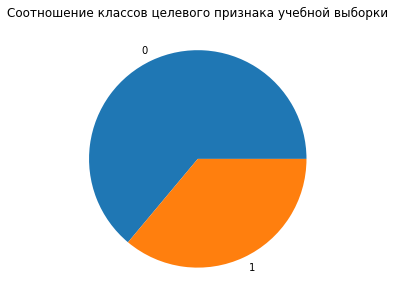

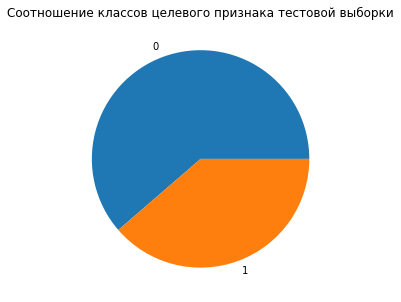

In [43]:

a = pd.DataFrame(target_train).groupby('is_canceled').size()
a.plot(kind='pie', subplots=True, figsize=(5, 5))
plt.title("Соотношение классов целевого признака учебной выборки")
plt.ylabel("")
plt.show()

b = pd.DataFrame(target_test).groupby('is_canceled').size()
b.plot(kind='pie', subplots=True, figsize=(5, 5))
plt.title("Соотношение классов целевого признака тестовой выборки")
plt.ylabel("")
plt.show()

Для построения модели предсказаний из учебной и тестовой выборок созданы выборки, содержащие признаки и целевой признак.

Целевой признак содержится в столбце 'is_canceled', поскольку целью построения модели является предсказание факта отказа потенциального клиента от брони.

Среди остальных признаков (столбцов) удалены так называемые фиктивные признаки, которые не могут и не должны влиять на предсказания будущей модели относительно факта отказа клиента от брони -  столбцы 'id', 'is_canceled', 'arrival_date_year', 'arrival_date_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'arrival_date_day_of_month','distribution_channel', 'booking_changes', 'sample', 'coefficient', 'room_price','room_prepare', 'profit'.
    
Для преобразования данных в численные мы применили метод прямого кодирования (OHE) get_dummies() с аргументом drop_first=True. также масштабировали признаки 'lead_time', 'arrival_date_week_number'.
    
Исследованием баланса классов целевого признака установлено, что соотношение классов на учебном датасете составляет 1.77, на тестовой выборке - 1.59. Для устранения дисбаланса применим метод взвешивания классов.

### Исследование метрик кросс-валидацией

Для решения вопроса о том, какую лучше модель предсказаний предложить заказчику методом кроссвалидации определим средние значения метрик accuracy, F1-меры и AUC ROC. 

Для визуализации данных сохраним их в отдельных переменных.

Проверяем кросс-валидацией метрики качества "Случайного леса" 

In [44]:
forest_model = RandomForestClassifier(random_state=12345, class_weight='balanced') 
acur_score = cross_val_score(forest_model,features_train, target_train, cv=10 , scoring= 'accuracy')
roc_auc = cross_val_score(forest_model, features_train, target_train, cv=10, scoring = 'roc_auc')
f_score = cross_val_score(forest_model,features_train, target_train, cv=10 , scoring='f1')
f_score_mean = f_score.mean()
roc_auc_mean = roc_auc.mean()
accuracy_mean = acur_score.mean()

print('Средняя Акураси-мера:', accuracy_mean)
print('Средняя F1-мера:', f_score_mean)
print('Средняя AUC ROC:',roc_auc_mean)

c = ['RF', round((accuracy_mean),2)
     ,round((f_score_mean),2)
     ,round((roc_auc_mean),2)]
c

Средняя Акураси-мера: 0.6927672244762201
Средняя F1-мера: 0.5583514555737569
Средняя AUC ROC: 0.7341947912278903


['RF', 0.69, 0.56, 0.73]

Проверяем кросс-валидацией метрики качества "Логистической регрессии"

In [45]:
log_model = LogisticRegression(random_state= 12345, class_weight='balanced', solver = 'liblinear') 
acur_score = cross_val_score(log_model,features_train, target_train, cv=10 , scoring= 'accuracy')
roc_auc = cross_val_score(log_model, features_train, target_train, cv=10, scoring = 'roc_auc')
f_score = cross_val_score(log_model,features_train, target_train, cv=10 , scoring='f1')
f_score_mean = f_score.mean()
roc_auc_mean = roc_auc.mean()
accuracy_mean = acur_score.mean()

print('Средняя Акураси-мера:', accuracy_mean)
print('Средняя F1-мера:', f_score_mean)
print('Средняя AUC ROC:',roc_auc_mean)

d = ['LR', round((accuracy_mean),2)
     ,round((f_score_mean),2)
     ,round((roc_auc_mean),2)]
d

Средняя Акураси-мера: 0.7141568215949133
Средняя F1-мера: 0.6201205644710925
Средняя AUC ROC: 0.7856398375839173


['LR', 0.71, 0.62, 0.79]

Проверяем кросс-валидацией метрики качества "Дерева решений "

In [46]:
model_tree = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
acur_score = cross_val_score(model_tree,features_train, target_train, cv=10 , scoring= 'accuracy')
roc_auc = cross_val_score(model_tree, features_train, target_train, cv=10, scoring = 'roc_auc')
f_score = cross_val_score(model_tree,features_train, target_train, cv=10 , scoring='f1')
f_score_mean = f_score.mean()
roc_auc_mean = roc_auc.mean()
accuracy_mean = acur_score.mean()

print('Средняя Акураси-мера:', accuracy_mean)
print('Средняя F1-мера:', f_score_mean)
print('Средняя AUC ROC:',roc_auc_mean)

f = ['DT', round((accuracy_mean),2)
     ,round((f_score_mean),2)
     ,round((roc_auc_mean),2)]
f

Средняя Акураси-мера: 0.6698378479859016
Средняя F1-мера: 0.5502007977169088
Средняя AUC ROC: 0.6994757380907932


['DT', 0.67, 0.55, 0.7]

,AUC ROC,Accuracy,F1-мера
model,,,
DT,0.70,0.67,0.55
LR,0.79,0.71,0.62
RF,0.73,0.69,0.56


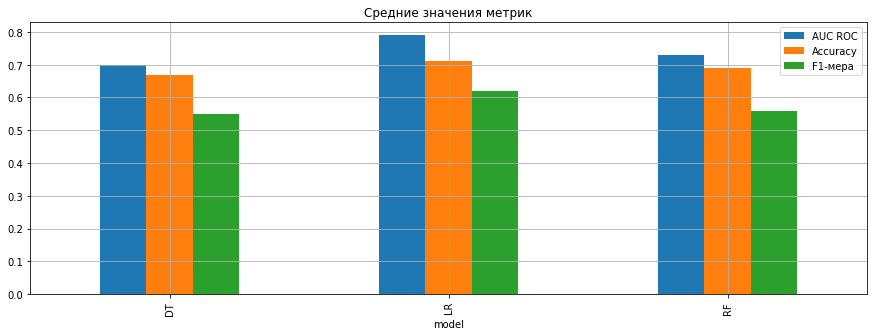

In [47]:
g = pd.DataFrame(data = [c, d, f],columns = ['model', 'Accuracy','F1-мера', 'AUC ROC'])
g = g.pivot_table(index='model', values=['Accuracy','F1-мера', 'AUC ROC'])
display(g)
ax = g.plot(grid=True, kind='bar', title='Средние значения метрик', figsize=(15, 5))

 Мы создали три модели машинного обучения "Случайный лес", "Логистическая регрессия" и "Дерево решений", в которых кросс-валидацией установили средние значения метрик качества  accuracy, F1-меры и AUC ROC.  
    
В качестве метрики, на которую будем ориентироваться при оценке качества моделей, изберем F1-меру, показывающую оптимальное соотношение полноты и точности предсказаний и матрицу ошибок. Метрика accuracy (доля правильных ответов)является малоиспользуемой, поскольку считается неэффективной в условиях дисбаланса классов (у нас присутствует), а AUC ROC (доля пар объектов класса 1 и класса 0, которые алгоритм верно предсказал) не так нагляда как матрица ошибок, которая покажет количество ложноотрицательных ответов, на минимизацию которых мы ориентируемся. 
    
Кросс-валидация показала, что наибольшее значение F1-меры = 0.62 у "Логистической регрессии", наименьшее - 0.55 - у "Дерева решений". Вместе с тем, данные значения средние и выведены без подбора гиперпараметров каждой конкретной модели. В этой связи построим и обучем все три модели с подбором гиперпараметров и выберем ту, что покажет наилучшие значения F1-меры и матрицы ошибок. 

### Подбор гиперпараметров и построение моделей

Для визуализации метрики AUC ROC создадим функцию для построения графиков для каждой модели

In [48]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")

#### "Случайный лес"

Подбираем гиперпараметры для лучшей F1-меры

In [49]:
parametrs = {'min_samples_leaf': range (1,5),
             'max_depth': range (1, 10)}
forest_model = GridSearchCV(RandomForestClassifier(random_state=12345), parametrs, scoring='f1')
forest_model.fit(features_train, target_train)
print("Гиперпараметры для лучшей F1-меры модели 'Случайный лес':",forest_model.best_params_)

Гиперпараметры для лучшей F1-меры модели 'Случайный лес': {'max_depth': 9, 'min_samples_leaf': 2}


Строим модель "Случайный лес"

F1-мера: 0.62
AUC ROC: 0.77
confusion matrix:
[[15470  4181]
 [ 4963  7421]]


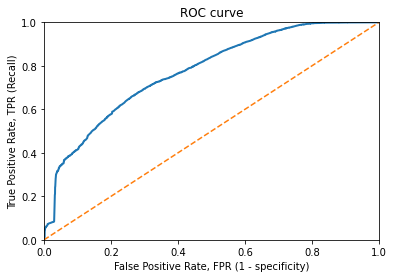

AUC ROC Случайного леса: 0.7743
CPU times: total: 3.38 s
Wall time: 3.47 s


In [50]:
%%time
forest_model = RandomForestClassifier(
    random_state=12345,  min_samples_leaf = 2,  max_depth = 9, class_weight='balanced')
forest_model.fit(features_train, target_train)        
forest_predictions = forest_model.predict(features_test)

print("F1-мера:", round((f1_score(target_test, forest_predictions)),2))
print("AUC ROC:", round(roc_auc_score(target_test, (forest_model.predict_proba(features_test))[:, 1]),2))
print("confusion matrix:")
print(confusion_matrix(target_test,forest_predictions))

fpr, tpr, thresholds = roc_curve(target_test, forest_model.predict_proba(features_test)[:, 1]) 
plot_roc_curve(fpr, tpr)
plt.show()
print("AUC ROC Случайного леса:", round(roc_auc_score(
    target_test, (forest_model.predict_proba(features_test))[:, 1]),4))

#### "Логистическая регрессия" 

Подбираем гиперпараметры для лучшей F1-меры

In [51]:
best_s = None
best_f1 = 0
best_i = 0 
for i in range(1000,10000,1000):
    log_model = LogisticRegression(random_state=12345, max_iter = i, class_weight='balanced', solver = 'liblinear')
    log_model.fit(features_train, target_train)        
    log_predictions = log_model.predict(features_test)            
    result = f1_score(target_test, log_predictions)
    if result > best_f1:
        best_i = i
        best_f1 = result
                          
print("Лучшее значение f1 =", round((best_f1),2),  " при max_iter =", best_i)  

Лучшее значение f1 = 0.57  при max_iter = 1000


Строим модель "Логистическая регрессия"

F1-мера: 0.57
AUC ROC: 0.62
confusion matrix:
[[12012  7639]
 [ 4329  8055]]


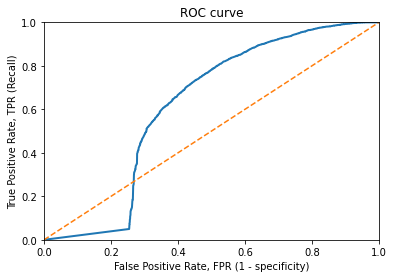

AUC ROC Логистической регрессии: 0.6179
CPU times: total: 609 ms
Wall time: 588 ms


In [52]:
%%time
log_model = LogisticRegression(random_state=12345, max_iter = 1000, solver='liblinear',class_weight='balanced')
log_model.fit(features_train, target_train)
log_predictions = log_model.predict(features_test) 

print("F1-мера:", round((f1_score(target_test, log_predictions)),2))
print("AUC ROC:", round(roc_auc_score(target_test, (log_model.predict_proba(features_test))[:, 1]),2))
print("confusion matrix:")
print(confusion_matrix(target_test,log_predictions)) 

fpr, tpr, thresholds = roc_curve(target_test, log_model.predict_proba(features_test)[:, 1]) 
plot_roc_curve(fpr, tpr)
plt.show()
print("AUC ROC Логистической регрессии:", round(roc_auc_score(
    target_test, (log_model.predict_proba(features_test))[:, 1]),4))

#### "Дерево решений"

Подбираем гиперпараметры для лучшей F1-меры

In [53]:
best_depth = 0
best_f1 = 0
best_msl = 0 
for depth in range(1,13, 2):
    for msl in range(1, 5):
        model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf = msl, class_weight='balanced')
        model_tree.fit(features_train, target_train)
        tree_predictions = model_tree.predict(features_test)
        result = f1_score(target_test, tree_predictions)
        result_r_a = roc_auc_score(target_test, (model_tree.predict_proba(features_test))[:, 1])
        if result > best_f1:
            best_depth = depth
            best_msl = msl
            best_f1 = result
        
print("Гиперпараметры для лучшей F1-меры Дерева решений:", round((best_f1),2), "при max_depth =", best_depth,
      "и min_samples_leaf =", best_msl) 

Гиперпараметры для лучшей F1-меры Дерева решений: 0.63 при max_depth = 7 и min_samples_leaf = 1


Строим с этими гиперпараметрами модель

F1-мера: 0.63
AUC ROC: 0.79
confusion matrix:
[[14791  4860]
 [ 4392  7992]]


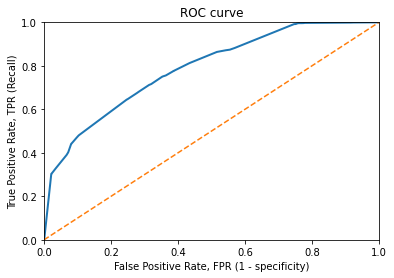

AUC ROC Дерева решений: 0.7873
CPU times: total: 344 ms
Wall time: 339 ms


In [54]:
%%time
model_tree = DecisionTreeClassifier(random_state=12345,max_depth=7, min_samples_leaf = 1,class_weight='balanced') 
model_tree.fit(features_train,target_train)
tree_predictions = model_tree.predict(features_test) 

print("F1-мера:", round((f1_score(target_test, tree_predictions)),2))
print("AUC ROC:", round(roc_auc_score(target_test, (model_tree.predict_proba(features_test))[:, 1]),2))
print("confusion matrix:")
print(confusion_matrix(target_test,tree_predictions))


fpr, tpr, thresholds = roc_curve(target_test, model_tree.predict_proba(features_test)[:, 1]) 
plot_roc_curve(fpr, tpr)
plt.show()
print("AUC ROC Дерева решений:", round(roc_auc_score(
    target_test, (model_tree.predict_proba(features_test))[:, 1]),4))



 Наивысшее значение F1-меры = 0.63 показало "Дерево решений" при max_depth = 7 и min_samples_leaf = 1. Также принята во внимание матрица ошибок, согласно которой количество ложноотрицательных ответов модели "Дерево решений" (4393) меньше, чем 4963, предсказанных "Случайным лесом".   
  
В данном проекте факт отказа клиента от заказа - целевой признак, в котором положительный класс 1 означает, что клиент отказался от брони и отель потерпит убытки. Отрицательный класс 0 означает, что клиент от заказа не отказался, что является позитивным показателем для отеля. В указанной связи более значимой для сети ошибкой предсказаний модели будет больший показатель ложноотрицательных ответов: модель предскажет, что клиент от заказа не откажется, а в действительности отель понесет только затраты без возмещения.
    
В нашем конкретном случае при исследовании метрик качества модели более приемлемой должна быть та, в которой при прочих равных матрица ошибок покажет наименьшее число ложноотрицательных ответов. Правильное предсказание возможного отказа клиента от брони поможет минимизировать количество  "ненадежных" бронирований без внесенения депозита и тем самым снизить убытки. Также не исключено, что факт внесения депозита сыграет ключевую роль при решении вопроса отказаться от брони или нет.       
  
    
По указанным причинам более предпочтительной является модель "Дерево решений", показавшая на тесте с гимерпараметрами max_depth = 7 и min_samples_leaf = 1 F1 = 0.63 и количество ложноотрицательных ответов - 4393.        
    

 В соответствии с рекомендацией проверяем модель "Дерево решений" на адекватность (в том смысле как это понято).
    
Для этого используем фиктивный классификатор DummyClassifier, который дополнительно импортируем из модуля библиотеки sklearn. С использованием этого классификатора построим модель, которая сделает прогнозы, не пытаясь найти закономерности в данных. Стратегией для создания прогнозов избирем "uniform", который сгенерирует прогнозы равномерно в случайном порядке.
    
Если метрики качества случайной модели окажутся меньше нашего "Дерева решений", будем считать, что наша модель, предложенная бизнесу для предсказаний отказа клиента от забронированного заказа, прошла проверку на адекватность.

In [55]:
from sklearn.dummy import DummyClassifier
dummy_classifier = DummyClassifier(strategy="uniform")
dummy_classifier.fit(features_train, target_train)    
test_predictions = dummy_classifier.predict(features_test)
probabilities_test = dummy_classifier.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
test_accuracy = accuracy_score(target_test, test_predictions)
test_f1_score = f1_score(target_test, test_predictions )
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)

print("Accuracy:", round((test_accuracy),2))
print("F1-мера:", round((test_f1_score),2))
print("AUC ROC:", round((auc_roc_test),2))
print("confusion matrix:")
print(confusion_matrix(target_test, test_predictions))

Accuracy: 0.5
F1-мера: 0.44
AUC ROC: 0.5
confusion matrix:
[[9916 9735]
 [6216 6168]]


 Избранные нами метрики качества F1-мера (0.44) и матрица ошибок (ложноотрицательных ответов 6177) случайной модели фиктивного классификатора хуже чем в построенном и обученном "Дереве решений" (0.63 и 4392 соответственно). Значит можно считать, что наша модель, предложенная бизнесу, прошла проверку на адекватность.

### Рассчет прибыли с учетом предсказаний модели

Для определения выгодности внедрения модели предсказаний напишем функцию, которая посчитает потенциальную прибыль отеля, если в условия бронирования включит внесение депозита в размере 80 % стоимости номера за день и однократного обслуживания (с учетом сезонного коэффициента).

Дополним тестовую выборку столбцом с предсказаниями модели, после чего телу функции (наряду с подсчетом прибыли без отказа от брони) передадим в условие подсчета убытков (в случае отказа) их уменьшение за счет внесения депозита для тех случаев, когда имел место фактический отказ и модель его предсказала. Прибыль с учетом депозита сохраним в столбце 'duposit'.

После этого посчитаем сумму прибыли, которую получил бы отель, если бы отказ от брони был предсказан:

просуммируем данные столбца 'duposit', из полученной суммы вычтем посчитаем прибыль отеля без внесения депозита (на тестовой выборке), просуммировав данные столбца 'profit', а также сумму внедрения модели, которая определена условием проекта и которую сохраним в переменной BUDGET_FORECAST.

In [56]:
BUDGET_FORECAST =  400000 

In [57]:
data_hotel_test['tree_predictions'] = tree_predictions


Функция по подсчету прибыли. 

In [58]:
def profit_test(row):
    if (row['tree_predictions'] == 1
       and row['is_canceled'] == 1):
        dep = ((row['room_price'] + row['room_prepare'])*row['coefficient'])*0.8 - ((row['room_price'] + row['room_prepare'])*row['coefficient'])          
    if row['is_canceled'] == 0:
        dep = row['room_price']*row['total_nights']*row['coefficient'] - row['room_prepare']*(np.ceil(row['total_nights']/2))*row['coefficient']
    if (row['tree_predictions'] == 0
       and row['is_canceled'] == 1):
        dep = 0 -((row['room_price'] + row['room_prepare'])*row['coefficient'])
    return dep
data_hotel_test['duposit'] = data_hotel_test.apply(profit_test, axis=1)
display(data_hotel_test)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,coefficient,room_price,room_prepare,profit,tree_predictions,duposit
0,6086,1,74,2017,January,1,1,1,0,2,...,Transient,0,0,1,1.0,1000,400,-1400,0,-1400.0
1,6087,1,62,2017,January,1,1,2,2,2,...,Transient,0,1,4,1.0,1000,400,-1400,0,-1400.0
2,6088,1,62,2017,January,1,1,2,2,2,...,Transient,0,1,4,1.0,1000,400,-1400,0,-1400.0
3,6089,1,71,2017,January,1,1,2,2,1,...,Transient,0,1,4,1.0,1000,400,-1400,0,-1400.0
4,6090,1,172,2017,January,1,1,2,5,2,...,Transient,0,0,7,1.0,1000,400,-1400,1,-280.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32030,97899,0,164,2017,August,35,31,2,4,2,...,Transient,0,0,6,1.4,1000,400,6720,1,6720.0
32031,97900,0,21,2017,August,35,30,2,5,2,...,Transient,0,2,7,1.4,1000,400,7560,0,7560.0
32032,97901,0,23,2017,August,35,30,2,5,2,...,Transient,0,0,7,1.4,1000,400,7560,1,7560.0
32033,97902,0,34,2017,August,35,31,2,5,2,...,Transient,0,4,7,1.4,550,150,4550,0,4550.0


Прибыль на тестовой выборке без учета депозита составила: 31332302 рублей
Прибыль на тестовой выборке с учетом депозита составит: 41142094.0 рублей
Чистая прибыль на тестовой выборке с учетом затрат на внедрение системы предсказаний составит: 9409792.0 рублей


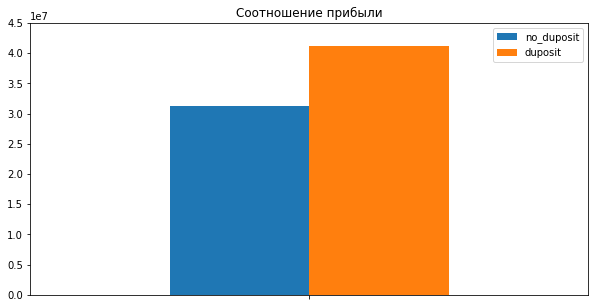

In [59]:
print('Прибыль на тестовой выборке без учета депозита составила:', data_hotel_test['profit'].sum(),'рублей')
print('Прибыль на тестовой выборке с учетом депозита составит:', data_hotel_test['duposit'].sum(),'рублей')
print('Чистая прибыль на тестовой выборке с учетом затрат на внедрение системы предсказаний составит:', 
      data_hotel_test['duposit'].sum() - data_hotel_test['profit'].sum() - BUDGET_FORECAST,'рублей')
ax = pd.DataFrame({'no_duposit': [data_hotel_test['profit'].sum()],'duposit': [data_hotel_test['duposit'].sum()]}, index = ['']
                 ).plot.bar(ylim=(0, 45000000), title='Соотношение прибыли', figsize=(10, 5))

 Мы произвели подсчет потенциальной прибыли заказчика, если бы наша модель предсказаний "Дерево решений" предсказала бы возможный отказ клиента,забронировавшего номер, от брони. 
    
Согласно рассчетам, если бы заказчик бронировал "ненадежным" клиентам номер на условиях внесения депозита, который бы при отказе от брони клиенту не возвращался, то в 2017 году его прибыль увеличилась бы на 9409792 рублей и составила 41142094 рублей.

Подсчитаем возможную чистую прибыль отельной сети за год. 
    
В тестовой выборке имеются данные за неполный год. Отсутствует информация за три осенних месяца  и 1 зимний (декабрь). Примерную чистую прибыль за указанный период можно вывести следующим образом:
    
посчитать среднюю чистую прибыль(согласно предсказаниям) за весенний месяц (весной и осенью одинаковый сезонный коэффициент 1.2), которую умножить на 3 - получим среднюю величину потенциальной чистой прибыли за осенние месяцы;
      
посчитать среднюю чистую прибыль (также согласно предсказаниям) за 1 зимний месяц;
    
сложить чистую прибыль, полученную нами согласно предсказаниям на основе тестовой выборки, прибавить среднюю чистую прибыль за 3 весенних и 1 зимний месяцы, вычесть бюджет, предусмотренный на внедрение модели.
    
Для указанных рассчетов создадим на основе тестовой выборки датафрейм с данными о прибыли с учетом депозита и без него, посчитаем чистую прибыль, которую сгруппируем по месяцам.

In [60]:
data_hotel_test['arrival_date_month'].value_counts()

May         5187
April       4783
June        4490
March       4249
July        3585
February    3531
January     3131
August      3079
Name: arrival_date_month, dtype: int64

Создаем датафрейм со столбцом чистой прибыли

In [61]:
p = data_hotel_test[['arrival_date_month', 'profit', 'duposit']].reset_index(drop=True)
p['net_profit'] = p['duposit'] - p['profit']
e = p.groupby('arrival_date_month')['net_profit'].sum().to_frame().reset_index()
e

,arrival_date_month,net_profit
0,April,1823808.0
1,August,676530.0
2,February,669680.0
3,January,578760.0
4,July,855717.0
5,June,2018001.0
6,March,1213488.0
7,May,1973808.0


Считаем потенциальную чистую прибыль за 3 осенних месяца

In [62]:
j = (e.query('arrival_date_month == ["April", "March", "May"]').reset_index(drop=True).mean())*3
j

net_profit    5011104.0
dtype: float64

Считаем потенциальную чистую прибыль за 1 зимний месяц

In [63]:
h = e.query('arrival_date_month == ["January", "February"]').reset_index(drop=True).mean()
h

net_profit    624220.0
dtype: float64

Считаем потенциальную чистую прибыль за год согласно предсказаниям с учетом затрат на внедрение модели предсказаний

In [64]:
all_net_profit = e['net_profit'].sum() + j + h - BUDGET_FORECAST
all_net_profit

net_profit    15045116.0
dtype: float64

 Чистая прибыль на тестовой выборке за 2017 год с учетом затрат на внедрение системы предсказаний составит 15045116 рублей. 

### Шаг 5. Опишите портрет «ненадёжного» клиента

По условию проекта нам необходимо описать портрет "ненадежного" клиента. Ненадежность заключается в отказе от ранее забронированного места в отеле. Основными чертами потенциально несостоявшегося клиента будут являться наиболее характерные значения, содержащиеся в признаках данных, выбранных по значению 'is_canceled'= 1 (если речь идет о лицах, фактически отказавшихся от брони), либо по значению 'tree_predictions'= 1 (если оечь идет о тех, кто откажется от брони согласно поредсказаним модели).

Чтобы получить типичный портрет "ненадежного" клиента сделаем выборки по указанным признакам из тестового набора данных, в зависимости от признака применим различные способы визуализации данных: построим гистограммы, иные графики, отсортируем признаки в порядке убывания. Одновременно оценим насколько портрет клиента, реально отказавшегося от брони соответствует признакам по предсказаниям.

In [65]:
test = data_hotel_test[['is_canceled', 'lead_time', 'arrival_date_month','stays_in_weekend_nights','stays_in_week_nights', 
                        'adults', 'children', 'babies', 'meal', 'country', 'distribution_channel', 'is_repeated_guest',
                        'previous_cancellations', 'previous_bookings_not_canceled','reserved_room_type', 'booking_changes', 
                        'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces', 'total_of_special_requests', 
                        'tree_predictions']]
test.head(3)

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,tree_predictions
0,1,74,January,1,0,2,0,0,BB,PRT,...,0,0,0,A,0,0,Transient,0,0,0
1,1,62,January,2,2,2,0,0,BB,AUT,...,0,0,0,A,0,0,Transient,0,1,0
2,1,62,January,2,2,2,0,0,BB,AUT,...,0,0,0,A,0,0,Transient,0,1,0


Выбираем данные по клиентам, фактически отказавшимся от брони

In [66]:
test_canceled = test.query('is_canceled == 1').reset_index(drop=True)
test_canceled.head(3)

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,tree_predictions
0,1,74,January,1,0,2,0,0,BB,PRT,...,0,0,0,A,0,0,Transient,0,0,0
1,1,62,January,2,2,2,0,0,BB,AUT,...,0,0,0,A,0,0,Transient,0,1,0
2,1,62,January,2,2,2,0,0,BB,AUT,...,0,0,0,A,0,0,Transient,0,1,0


Выделяем данные по клиентам, склонным к отказу от брони согласно предсказаниям

In [67]:
test_predictions = test.query('tree_predictions == 1').reset_index(drop=True)
test_predictions.head(3)

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,tree_predictions
0,1,172,January,2,5,2,0,0,BB,BEL,...,0,0,0,A,0,0,Transient,0,0,1
1,1,52,January,2,5,1,0,0,BB,DEU,...,0,0,0,A,0,0,Transient,0,0,1
2,1,89,January,1,3,2,0,0,BB,GBR,...,0,0,0,E,0,0,Transient,0,0,1


count    12384.000000
mean       120.396318
std         84.222431
min          0.000000
25%         51.000000
50%        108.000000
75%        175.000000
max        350.000000
Name: lead_time, dtype: float64

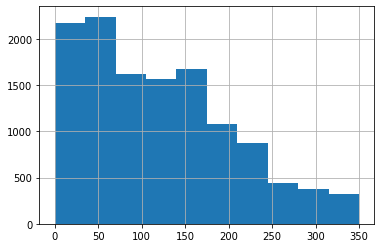

In [68]:
test_canceled['lead_time'].hist()
test_canceled['lead_time'].describe()

count    12852.000000
mean       102.919234
std         79.800049
min          0.000000
25%         34.000000
50%         91.000000
75%        157.000000
max        350.000000
Name: lead_time, dtype: float64

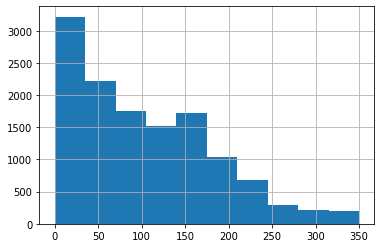

In [69]:
test_predictions['lead_time'].hist()
test_predictions['lead_time'].describe()

 Максимальное количество лиц, впоследствии фактически отказавшихся от брони, бронировали отель от 0 до 70 суток до дня предполагаемого заезда. Согласно предсказаниям этот срок находится в пределах 35 дней. 

In [70]:
print(test_canceled['booking_changes'].value_counts())
print(test_predictions['booking_changes'].value_counts())

0    11612
1      393
2      306
3       51
4       22
Name: booking_changes, dtype: int64
0    12492
2      218
1       93
3       37
4       12
Name: booking_changes, dtype: int64


 Изменения в ранее сделанный заказ и фактически и по предсказаниям такие клиенты вносят редко.

In [71]:
print(test_canceled['days_in_waiting_list'].value_counts().head())
print(test_predictions['days_in_waiting_list'].value_counts().head())

0     12314
46        4
44        4
28        4
16        4
Name: days_in_waiting_list, dtype: int64
0     12784
44        4
28        4
17        4
26        4
Name: days_in_waiting_list, dtype: int64


 Подтверждение брони клиенты получают в день заказа.

In [72]:
print(test_canceled['customer_type'].value_counts())
print(test_predictions['customer_type'].value_counts())

Transient          11614
Transient-Party      718
Contract              44
Group                  8
Name: customer_type, dtype: int64
Transient          12006
Transient-Party      774
Contract              47
Group                 25
Name: customer_type, dtype: int64


В основном  бронирование номеров не было связано с договором или групповым заездом.

In [73]:
print(test_canceled['previous_cancellations'].value_counts())
print(test_predictions['previous_cancellations'].value_counts())

0    12350
1       25
2        4
4        3
3        2
Name: previous_cancellations, dtype: int64
0    12823
1       25
2        3
6        1
Name: previous_cancellations, dtype: int64


In [74]:
print(test_canceled['previous_bookings_not_canceled'].value_counts().head())
print(test_predictions['previous_bookings_not_canceled'].value_counts().head())

0     12333
1        23
2        11
10        3
7         3
Name: previous_bookings_not_canceled, dtype: int64
0    12702
1       85
2       30
3       10
4        7
Name: previous_bookings_not_canceled, dtype: int64


  Данными об отмененных либо подтвержденных заказах по таким  лицам клиентская база практически не располагала.  

In [75]:
print(test_canceled['adults'].value_counts())
print(test_predictions['adults'].value_counts())

2    9785
1    1858
3     736
4       5
Name: adults, dtype: int64
2    10005
1     2121
3      721
4        5
Name: adults, dtype: int64


In [76]:
print(test_canceled['meal'].value_counts())
print(test_predictions['meal'].value_counts())

BB    9566
SC    2023
HB     782
FB      13
Name: meal, dtype: int64
BB    10362
SC     1806
HB      662
FB       22
Name: meal, dtype: int64


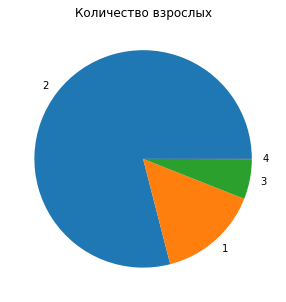

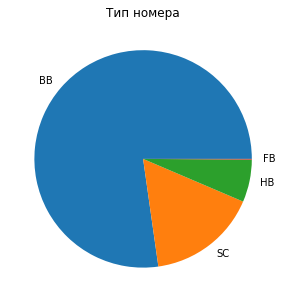

In [77]:
test_canceled['adults'].value_counts().plot(kind='pie', subplots=True, figsize=(5, 5))
plt.title("Количество взрослых")
plt.ylabel("")
plt.show()
test_canceled['meal'].value_counts().plot(kind='pie', subplots=True, figsize=(5, 5))
plt.title("Тип номера")
plt.ylabel("")
plt.show()

Клиенты, отказавшиеся от брони в подавляющем большинстве случаев  бронировали на 2 взрослых номера категории BB. 

In [78]:
print(test_canceled['children'].value_counts())
print(test_predictions['children'].value_counts())

0    11604
1      505
2      274
3        1
Name: children, dtype: int64
0    12187
1      405
2      259
3        1
Name: children, dtype: int64


In [79]:
print(test_canceled['babies'].value_counts())
print(test_predictions['babies'].value_counts())

0    12362
1       22
Name: babies, dtype: int64
0    12832
1       19
2        1
Name: babies, dtype: int64


 В заказ редко включались дети  и в единичных случаях - младенцы. 

In [80]:
print(test_canceled['required_car_parking_spaces'].value_counts())
print(test_predictions['required_car_parking_spaces'].value_counts())

0    12384
Name: required_car_parking_spaces, dtype: int64
0    12851
1        1
Name: required_car_parking_spaces, dtype: int64


 Места для автомобилей такие заказчики не бронировали.

<AxesSubplot:title={'center':'Топ - 10 - гражданство фактически отказавшихся от брони'}>

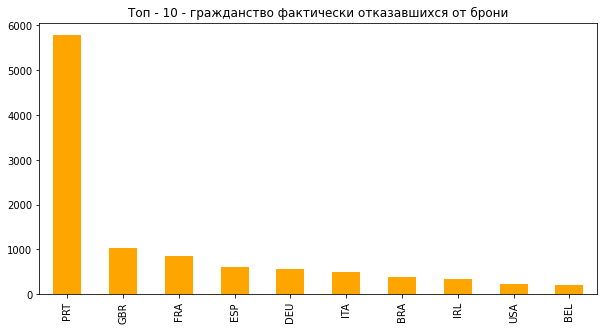

In [81]:
g = test_canceled['country'].value_counts().head(10)
g.plot(kind='bar', y='share_knowns', title='Топ - 10 - гражданство фактически отказавшихся от брони', 
       color = 'orange', figsize =(10, 5))

<AxesSubplot:title={'center':'Топ - 10 - гражданство отказавшихся от брони по предсказаниям'}>

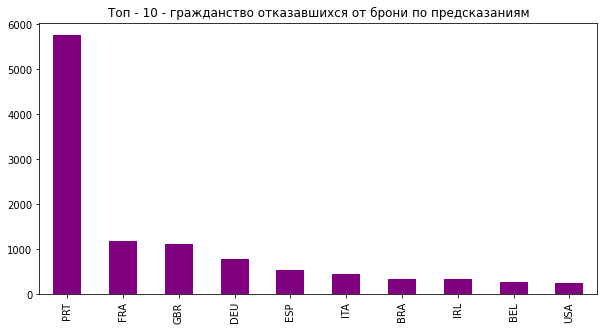

In [82]:
k = test_predictions['country'].value_counts().head(10)
k.plot(kind='bar', y='share_knowns', title='Топ - 10 - гражданство отказавшихся от брони по предсказаниям', 
       color = 'purple', figsize =(10, 5))

Лидерами по отмене заказанных номеров (почти половина ото всех) являются граждане Португалии. В 10 стран, чьи граждане склонны отменять бронь вошли Франция, Испания, Дания, Италия, Ирландия, Бразилия, США, Беларусь. Выборки фактически отказавшихся и чей отказ предсказала модель по набору стран не отличаются, незначительно отличается распределение количества между этими странами. 

May         2275
April       2114
June        2000
March       1400
July        1306
February    1130
August      1095
January     1064
Name: arrival_date_month, dtype: int64


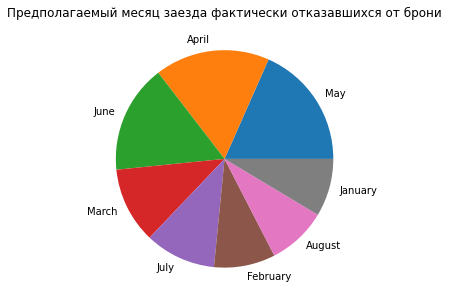

In [83]:
print(test_canceled['arrival_date_month'].value_counts())
test_canceled['arrival_date_month'].value_counts().plot(kind='pie', subplots=True, figsize=(5, 5))
plt.title("Предполагаемый месяц заезда фактически отказавшихся от брони")
plt.ylabel("")
plt.show()

May         2361
June        2139
April       2103
March       1863
February    1236
July        1222
January     1006
August       922
Name: arrival_date_month, dtype: int64


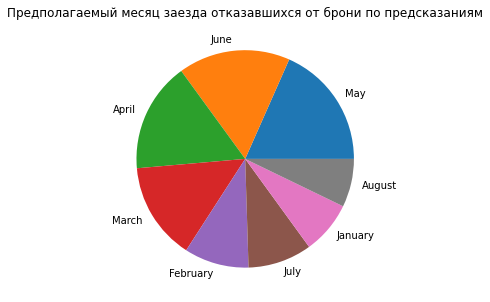

In [84]:
print(test_predictions['arrival_date_month'].value_counts())
test_predictions['arrival_date_month'].value_counts().plot(kind='pie', subplots=True, figsize=(5, 5))
plt.title("Предполагаемый месяц заезда отказавшихся от брони по предсказаниям")
plt.ylabel("")
plt.show()

 По времени года больше всего отказов от брони приходится на май, апрель, июнь, март.

0    5368
2    3624
1    3337
3      31
4      24
Name: stays_in_weekend_nights, dtype: int64

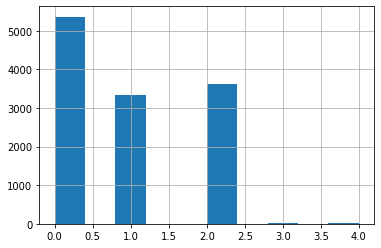

In [85]:
test_canceled['stays_in_weekend_nights'].hist()
test_canceled['stays_in_weekend_nights'].value_counts()

0    5359
2    3835
1    3601
4      30
3      27
Name: stays_in_weekend_nights, dtype: int64

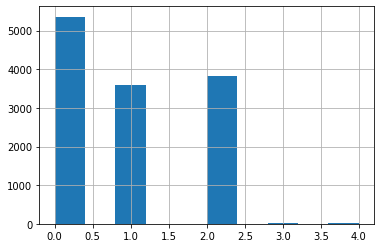

In [86]:
test_predictions['stays_in_weekend_nights'].hist()
test_predictions['stays_in_weekend_nights'].value_counts()

2    3728
3    3143
1    2648
4    1156
5    1031
0     576
6     102
Name: stays_in_week_nights, dtype: int64

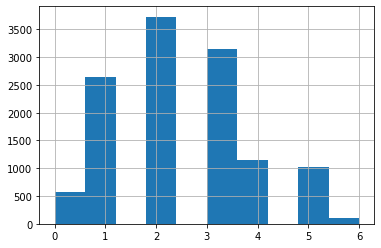

In [87]:
test_canceled['stays_in_week_nights'].hist()
test_canceled['stays_in_week_nights'].value_counts()

2    3818
3    3188
1    2861
4    1141
5    1063
0     688
6      93
Name: stays_in_week_nights, dtype: int64

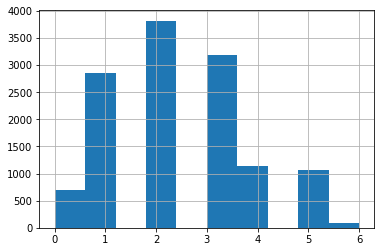

In [88]:
test_predictions['stays_in_week_nights'].hist()
test_predictions['stays_in_week_nights'].value_counts()

 Примерно в 40 % отмененных заказов отсутствовала бронь на выходные дни, 1 или 2 выходных - по 30 % отмен. Заказы 3-4 выходных дней отменялись крайне редко. Забронированные на будничные дни наиболее часто отменялись заказы на 1-3 дня.

 По условию проекта проанализированы данные на предмет выявления типичных признаков, указывающих на то, что клиент, забронировавший место в отеле, впоследствие откажется от брони. Предметом анализа явились признаки тестовой выборки, отсортированные по лицам, фактически отказавшимся от брони в отеле, а также по таким лицам согласно предсказаниям модели. В целом соотношение значений признаков в обоих случаях совпадает. Типичными чертами "ненадежного" клиента являются следующие.
    
Бронирование отеля в срок от 0 до 70 суток до дня предполагаемого заезда с подтверждением брони в день заказа. Как правило, бронирование номеров не было связано с договором или групповым заездом.Изменения в ранее сделанный заказ такими клиентами вносятся редко. Данными об отмененных либо подтвержденных заказах по этим лицам клиентская база практически не располагала.

Клиенты, склонные к отказу от брони в подавляющем большинстве случаев бронируют номера категории BB на 2 взрослых . В заказ редко включаются дети, в единичных случаях - младенцы. Места для автомобилей такими заказчиками не бронируются. 
    
Лидерами по отмене заказанных номеров (почти половина ото всех) являются граждане Португалии. В 10 стран, чьи граждане склонны отменять бронь вошли Франция, Испания, Дания, Италия, Ирландия, Бразилия, США, Беларусь. 
    
По времени года больше всего отказов от брони в мае, апреле, июне, июле, по дням недели - скорее отменяют заказы клиенты, забронировавшие места на 1-з будничных дня. 

### Общий вывод

 По заказу сети отелей «Как в гостях» мы построили модель машинного обучения, предсказывающую на основе данных о клиентах при бронировании отеля возможный отказ от брони для применения в их отношении системы бролнирования номеров при условии внесения депозита с целью минимизации убытков отеля.
    
Бюджет заказа определен в 400000 рублей. В распоряжение представлены данные клиентских систем за 2015-2016 годы - для обучения модели и за 2017 год - для тестирования. 
    
Перед началом исследования проведена предварительная обработка данных: типы столбцов 'lead_time', 'adults', 'children', 'babies'из "float", сделали цельночисленными; неявные дубликаты в столбце 'meal', образовавшиеся за счет пробелов ('SC' и 'SC ') устранили методом str.strip(), этим же методом устранили пробелы в значениях столбца 'reserved_room_type'; в столбцах lead_time', 'adults', 'babies','booking_changes','days_in_waiting_list' удалили значения, являющиеся выбросами. После потеря данных в учебном датасете составила 4 %, в тестовом - 1 %, что приемлемо для проведения исследовательского анализа и построения модели предсказаний.
    
 
Для вычисления бизнес-метрики отеля мы написали функцию. Прибыль на учебной выборке составила: за 2015 год  -16592635 рублей, 2016 -47526595 рублей, общая прибыль -64119230 рублей. Из прибыли исключены затраты при отказе потенциального клиента от брони.
    
Бизнес-задачей является минимизация убытков отеля при отказе клиента от забронированного номера путем бронирования номеров при условии внесения депозита, который не возвращается при отказе от брони. Условие депозита необходимо применять только к склонным к отказу от брони клиентам, чтоб "не отпугнуть" депозитом потенциальных "благонадежных" клиентов.

Для решения этой бизнес-задачи построено несколько моделей машинного обучения, способных на основе данных о клиентах, которые поступают в распоряжение отелей при бронировании номера, распознавать возможность последующего отказа от брони: "Случайный лес", "Дерево решений" и "Логистическая регрессия". В качестве метрики при оценке качества моделей, избрана F1-меру, показывающую оптимальное соотношение полноты и точности предсказаний и матрица ошибок, которая покажет количество ложноотрицательных ответов, на минимизацию которых мы ориентировались.  
    
В данном проекте факт отказа клиента от заказа - целевой признак, в котором положительный класс 1 означает, что клиент отказался от брони и отель потерпит убытки. Отрицательный класс 0 означает, что клиент от заказа не отказался, что является позитивным показателем для отеля. В указанной связи более значимой для сети ошибкой предсказаний модели будет больший показатель ложноотрицательных ответов: модель предскажет, что клиент от заказа не откажется, а в действительности отель понесет только затраты без возмещения.
    
   
В этой связи более предпочтительной является модель "Дерево решений", показавшая на тесте с гимерпараметрами max_depth = 7 и min_samples_leaf = 1 F1 = 0.63 и количество ложноотрицательных ответов - 4392.        
    
Мы произвели подсчет потенциальной прибыли заказчика, если бы наша модель предсказаний "Дерево решений" предсказала бы возможный отказ клиента,забронировавшего номер, от брони. Согласно рассчетам, если бы заказчик бронировал "ненадежным" клиентам номер на условиях внесения депозита, который бы при отказе от брони клиенту не возвращался, то в 2017 году его прибыль увеличилась бы на  15056652 рублей.      
    
По условию проекта проанализированы данные на предмет выявления типичных признаков, указывающих на то, что клиент, забронировавший место в отеле, впоследствие откажется от брони. Типичные черты "ненадежного" клиента, фактически отказавшегося от брони, а также являющегося таковым по предсказаниям, совпадают. А именно:
    
бронирование отеля в срок от 0 до 70 суток до дня предполагаемого заезда с подтверждением брони в день заказа; бронирование  номеров не связано с договором или групповым заездом; редкие изменения в ранее сделанный заказ, отсутствие в клиентской базе данных об отмененных либо подтвержденных заказах по этим лицам;

клиенты, склонные к отказу от брони в подавляющем большинстве случаев бронируют номера категории BB на 2 взрослых; в заказ редко включаются дети, в единичных случаях - младенцы; места для автомобилей такими заказчиками не бронируются;

лидерами по отмене заказанных номеров (почти половина ото всех) являются граждане Португалии; в 10 стран, чьи граждане склонны отменять бронь, вошли Франция, Испания, Дания, Италия, Ирландия, Бразилия, США, Беларусь.

по времени года больше всего отказов от брони в мае, апреле, июне, июле, по дням недели - скорее отменяют заказы клиенты, забронировавшие места на 1-3 будничных дня.
        
По результатам проведенного исследования возможно предложить заказчику внедрить модель предсказаний "Дерево решений" (при max_depth = 7 и min_samples_leaf = 1) для предсказания возможного отказа клиента, забронировавшего номер, от заказа и бронирование номеров для таких лиц на условиях педварительного внесения депозита, который в случае отказа от брони не возвращается. Условие депозита необходимо применять только к склонным к отказу от брони клиентам, чтоб "не отпугнуть" депозитом потенциальных "благонадежных" клиентов. За счет работы модели чистая прибыль отельной сети может возрасти на 15 млн. рублей в год, не считая случаев, когда внесение депозита станет ключевым условием при решении отказа клиента от заказа.      